# Clone the repo
##### Source is : https://towardsdatascience.com/finetune-a-facial-recognition-classifier-to-recognize-your-face-using-pytorch-d00a639d9a79

In [1]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
import os 
#os.chdir('/content/drive/My Drive/EVA4/phase2/s4_faceRecognition')
#!git clone https://github.com/timesler/facenet-pytorch.git

In [3]:
os.chdir('/content/drive/My Drive/EVA4/phase2/s4_faceRecognition/detectMyFace_project')

In [4]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from models.inception_resnet_v1 import InceptionResnetV1
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'data/test_me_aligned_bkp'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# Get pretrained ResNet on VGGFace2 dataset

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
from models.inception_resnet_v1 import InceptionResnetV1
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

Running on device: cuda


# Freeze early layers

In [9]:
list(model_ft.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [10]:
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [11]:
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

In [12]:
model_ft

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

## If training just final layers:

In [13]:
for param in model_ft.parameters():
    param.requires_grad = False

In [14]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [15]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)

In [16]:
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [17]:
model_ft.logits = nn.Linear(512, len(class_names))
model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)

In [18]:
model_ft

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

In [19]:
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

Epoch 0/499
----------
train Loss: 1.3870 Acc: 0.1316
val Loss: 1.3865 Acc: 0.1765
Epoch 1/499
----------
train Loss: 1.3816 Acc: 0.3947
val Loss: 1.3790 Acc: 0.5882
Epoch 2/499
----------
train Loss: 1.3726 Acc: 0.8684
val Loss: 1.3693 Acc: 1.0000
Epoch 3/499
----------
train Loss: 1.3619 Acc: 1.0000
val Loss: 1.3584 Acc: 1.0000
Epoch 4/499
----------
train Loss: 1.3494 Acc: 1.0000
val Loss: 1.3461 Acc: 1.0000
Epoch 5/499
----------
train Loss: 1.3392 Acc: 1.0000
val Loss: 1.3343 Acc: 1.0000
Epoch 6/499
----------
train Loss: 1.3258 Acc: 1.0000
val Loss: 1.3226 Acc: 1.0000
Epoch 7/499
----------
train Loss: 1.3150 Acc: 1.0000
val Loss: 1.3111 Acc: 1.0000
Epoch 8/499
----------
train Loss: 1.3064 Acc: 1.0000
val Loss: 1.2995 Acc: 1.0000
Epoch 9/499
----------
train Loss: 1.2900 Acc: 1.0000
val Loss: 1.2893 Acc: 1.0000
Epoch 10/499
----------
train Loss: 1.2749 Acc: 1.0000
val Loss: 1.2792 Acc: 1.0000
Epoch 11/499
----------
train Loss: 1.2647 Acc: 1.0000
val Loss: 1.2688 Acc: 1.0000
Ep

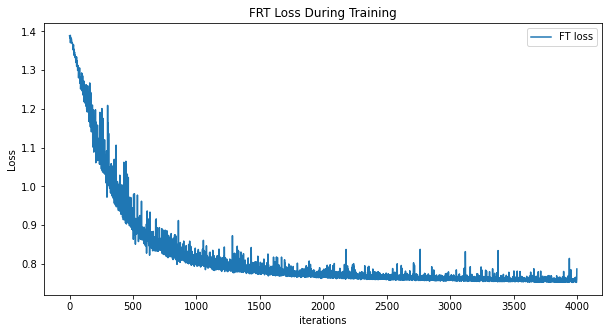

In [21]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=500)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
traced_model = torch.jit.trace(model_ft.float(), torch.randn(1,3,150,150).to(device))
torch.jit.save(traced_model, 'detectMyFace_suman.pt')

In [23]:
from torchsummary import summary
summary(model_ft,input_size=(3,150,150))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 74, 74]             864
       BatchNorm2d-2           [-1, 32, 74, 74]              64
              ReLU-3           [-1, 32, 74, 74]               0
       BasicConv2d-4           [-1, 32, 74, 74]               0
            Conv2d-5           [-1, 32, 72, 72]           9,216
       BatchNorm2d-6           [-1, 32, 72, 72]              64
              ReLU-7           [-1, 32, 72, 72]               0
       BasicConv2d-8           [-1, 32, 72, 72]               0
            Conv2d-9           [-1, 64, 72, 72]          18,432
      BatchNorm2d-10           [-1, 64, 72, 72]             128
             ReLU-11           [-1, 64, 72, 72]               0
      BasicConv2d-12           [-1, 64, 72, 72]               0
        MaxPool2d-13           [-1, 64, 35, 35]               0
           Conv2d-14           [-1, 80,

# Load the model

In [24]:
model_test = torch.jit.load('/content/drive/My Drive/EVA4/phase2/s4_faceRecognition/detectMyFace_project/detectMyFace_suman.pt')
list(model_test.children())

[RecursiveScriptModule(
   original_name=BasicConv2d
   (conv): RecursiveScriptModule(original_name=Conv2d)
   (bn): RecursiveScriptModule(original_name=BatchNorm2d)
   (relu): RecursiveScriptModule(original_name=ReLU)
 ), RecursiveScriptModule(
   original_name=BasicConv2d
   (conv): RecursiveScriptModule(original_name=Conv2d)
   (bn): RecursiveScriptModule(original_name=BatchNorm2d)
   (relu): RecursiveScriptModule(original_name=ReLU)
 ), RecursiveScriptModule(
   original_name=BasicConv2d
   (conv): RecursiveScriptModule(original_name=Conv2d)
   (bn): RecursiveScriptModule(original_name=BatchNorm2d)
   (relu): RecursiveScriptModule(original_name=ReLU)
 ), RecursiveScriptModule(original_name=MaxPool2d), RecursiveScriptModule(
   original_name=BasicConv2d
   (conv): RecursiveScriptModule(original_name=Conv2d)
   (bn): RecursiveScriptModule(original_name=BatchNorm2d)
   (relu): RecursiveScriptModule(original_name=ReLU)
 ), RecursiveScriptModule(
   original_name=BasicConv2d
   (conv): 